In [ ]:
"""

HW2-576

"""

### 1. Modify your neural network from problem 3 of Assignment 1 to use binary classification instead of mean-square error. Evaluate your new neural network with your XOR test dataset generated in the previous assignment. Compare your modified neural network with your previous one (from last assignment), and write down your discovery.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F	
import torch.optim as optim	
from torchvision import datasets, transforms,utils
import os
import scipy.io as sio
import numpy as np
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable


In [3]:
use_cuda = torch.cuda.is_available()
use_cuda = False

In [4]:
class Neuralnetwork(nn.Module):
    def __init__(self, input_dim=2, output_dim=1,nLinear1=4, nLinear2=4):
        super(Neuralnetwork, self).__init__()
        self.lin1 = nn.Linear(input_dim, nLinear1)
        self.lin2 = nn.Linear(nLinear1, nLinear2)
        self.lin3 = nn.Linear(nLinear2, output_dim)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = self.lin2(x)
        x = torch.sigmoid(x)
        x = self.lin3(x)
        return x

def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.normal_(-1, 1)
            

In [5]:
model = Neuralnetwork()
print(model)  # net architecture
weights_init(model)

Neuralnetwork(
  (lin1): Linear(in_features=2, out_features=4, bias=True)
  (lin2): Linear(in_features=4, out_features=4, bias=True)
  (lin3): Linear(in_features=4, out_features=1, bias=True)
)


In [6]:
 #Loss function 
m = nn.Sigmoid()
criterion = nn.BCELoss()

In [7]:
# training function
def train(model, learning_rate, criterion, data, idx_list):

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    optimizer.zero_grad()

    nPoints = len(idx_list)
    inputs = []
    targets = []
    loss = 0

    for i in idx_list:
        inputs.append(data[0][i])
        targets.append(data[1][i])

    inputs = torch.Tensor(inputs)
    targets = torch.Tensor(targets)
    output = model(inputs)

    loss += criterion(m(output.view(-1)), targets)

    loss.backward()
    optimizer.step()

    return loss.item(), nPoints

In [8]:
# a function that creates data 
def create_data(npoints):
    #random.seed(1)

    x = []
    y = []
    for i in range(npoints):
        #x0 = (torch.rand(npoints) - 0.5) * 2
        x0 = np.random.randint(-10, 10)/10
        #x1 = (torch.rand(npoints) - 0.5) * 2
        x1 = np.random.randint(-10, 10)/10
        label = 0 if x0 * x1 > 0 else 1
        x.append([x0, x1])
        y.append(label)
    x = np.asarray(x)
    y = np.asarray(y)

    return [x, y]

In [9]:
# create train_data,dev_data and test_data
datapoints = 10000
train_data = create_data(int(0.8*datapoints))
dev_data = create_data(int(0.1*datapoints))
test_data = create_data(int(0.1*datapoints))

In [10]:
DataPoints = len(train_data[0])
train_list = [i for i in range(len(train_data[0]))]           
dev_list = [i for i in range(len(dev_data[0]))]   
test_list = [i for i in range(len(test_data[0]))]

In [15]:
#Train and tune the neural net with your XOR train dataset
batch_size = 10
nEpochs = 20 
learning_rate = 0.01


In [16]:
# train XOR model
for epoch in range(nEpochs):
    np.random.shuffle(train_list)
    TrainLoss = 0
    TrainPoints = 0
    
    for i in range(0, DataPoints, batch_size):
        loss, nPoints = train(model, learning_rate, criterion, train_data, train_list[i:i+batch_size])
        TrainLoss += loss
        TrainPoints += nPoints
    
    if epoch % (nEpochs/10) == 0:
        print(f'Epoch: {epoch}, Loss: {TrainLoss/TrainPoints:.6f}')

Epoch: 0, Loss: 0.023619
Epoch: 2, Loss: 0.022259
Epoch: 4, Loss: 0.021016
Epoch: 6, Loss: 0.019884
Epoch: 8, Loss: 0.018841
Epoch: 10, Loss: 0.017865
Epoch: 12, Loss: 0.016982
Epoch: 14, Loss: 0.016149
Epoch: 16, Loss: 0.015379
Epoch: 18, Loss: 0.014651


In [17]:
x, y = test_data
out = model(torch.Tensor(x))
out = nn.Sigmoid()(out)
out = out.detach().cpu().numpy()[:,0]
mse = (((y - out)**2).sum()) / len(y)
print(f'mean squared error for test data = {mse}')

mean squared error for test data = 0.029137970501316838


### Comparing with the MSE :
(1) For the same train data size, BCEloss is larger than mseloss

(2)BCEloss converges faster

(3)If using BCE, the input must be between 0 and 1.

### 2. Modify your new XOR neural network to include an L2 regularization. Evaluate the new neural network with your XOR test dataset generated in the previous assignment. Compare your new neural network with the previous one(from this assignment), and write down your discovery

In [ ]:
#The weight_decay parameter in optim.SGD adds a L2 penalty to the cost which can effectively lead to to smaller model weights. 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

In [18]:
# training function
def train1(model, learning_rate, criterion, data, idx_list):

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)
    
    optimizer.zero_grad()

    nPoints = len(idx_list)
    inputs = []
    targets = []
    loss = 0

    for i in idx_list:
        inputs.append(data[0][i])
        targets.append(data[1][i])

    inputs = torch.Tensor(inputs)
    targets = torch.Tensor(targets)
    output = model(inputs)

    loss += criterion(m(output.view(-1)), targets)

    loss.backward()
    optimizer.step()

    return loss.item(), nPoints

In [19]:
# train XOR model
for epoch in range(nEpochs):
    np.random.shuffle(train_list)
    TrainLoss = 0
    TrainPoints = 0
    
    for i in range(0, DataPoints, batch_size):
        loss, nPoints = train1(model, learning_rate, criterion, train_data, train_list[i:i+batch_size])
        TrainLoss += loss
        TrainPoints += nPoints
    
    if epoch % (nEpochs/10) == 0:
        print(f'Epoch: {epoch}, Loss: {TrainLoss/TrainPoints:.6f}')

Epoch: 0, Loss: 0.014112
Epoch: 2, Loss: 0.014035
Epoch: 4, Loss: 0.013970
Epoch: 6, Loss: 0.013900
Epoch: 8, Loss: 0.013845
Epoch: 10, Loss: 0.013781
Epoch: 12, Loss: 0.013740
Epoch: 14, Loss: 0.013688
Epoch: 16, Loss: 0.013642
Epoch: 18, Loss: 0.013594


In [20]:
x, y = test_data
out = model(torch.Tensor(x))
out = nn.Sigmoid()(out)
out = out.detach().cpu().numpy()[:,0]
mse = (((y - out)**2).sum()) / len(y)
print(f'mean squared error for test data = {mse}')

mean squared error for test data = 0.026179354803523302


The result shows that using L2 regularization converges faster and the result is more stable.

## non-coding question

### 1. Learning-rate is a hyperparameter that controls the behavior of the optimizer. How does learning-rate affect the training process of a neural network? Step size is the size of the update of parameters during gradient descent. Should the step size always be the same through the whole training process? Why or why not? Use examples to justify your answer

The learning rate determines whether the objective function can converge to a local minimum and when to converge to a minimum. A proper learning rate can make the objective function converge to a local minimum in a suitable time.When the learning rate is set too small, the convergence process becomes very slow. When the learning rate is set too large, the gradient may oscillate around the minimum value and may not even converge or diverge.

The step size shouldn't always be the same. Since it can help you to find a more accurate answer if you change the learning rate to suitable size in different trials. The following is the example which is the fucntion used in last homework.The function is f(x, y) = 3(x^2 − y)^2 + 4(y^2 − x)^2 and using gradient descent and draw the plot to explain.

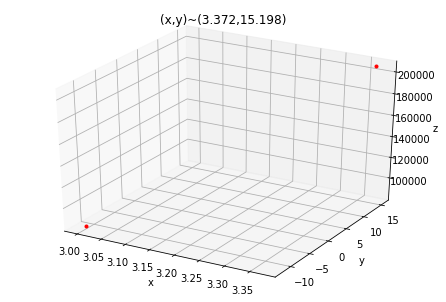

the minimum of function f(x,y) is  207264.10918352086
The time it spend is: 1.289097785949707


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
 
def Fun(x,y):
    return 3*(x**2-y)**2 + 4*(y**2-x)**2
def PxFun(x,y):
    return (12*x*(x**2-y)+8*x-8*y**2) 
def PyFun(x,y):
    return (-6*x**2+16*y*(-x+y**2)+6*y)

start = time.time()


fig=plt.figure()
ax=Axes3D(fig)
X,Y=np.mgrid[-2:2:40j,-2:2:40j]
Z=Fun(X,Y)
#ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap="rainbow")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
 
#gradient descent
step=0.001
x=3
y=-12
tag_x=[x]
tag_y=[y]
tag_z=[Fun(x,y)]
new_x=x
new_y=y
Over=False
while Over==False:
    new_x-=step*PxFun(x,y)
    new_y-=step*PyFun(x,y)
    if Fun(x,y)-Fun(new_x,new_y)<1e-5:
        Over=True
    x=new_x
    y=new_y#更新旧点
    tag_x.append(x)
    tag_y.append(y)
    tag_z.append(Fun(x,y))


ax.plot(tag_x,tag_y,tag_z,'r.')
plt.title('(x,y)~('+str(x)+","+str(y)+')')
plt.show()
#print(x,y)
end = time.time()
print("the minimum of function f(x,y) is ",Fun(x,y))
print("The time it spend is:",(end-start))

The minmum suppose be 0 at point(0,0). However,this plot shows us that if I set step size as 0.01,this step is too large thus the gradient diverge and thus can't find the minimum.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
 
def Fun(x,y):
    return 3*(x**2-y)**2 + 4*(y**2-x)**2
def PxFun(x,y):
    return (12*x*(x**2-y)+8*x-8*y**2) 
def PyFun(x,y):
    return (-6*x**2+16*y*(-x+y**2)+6*y)

start = time.time()


fig=plt.figure()
ax=Axes3D(fig)
X,Y=np.mgrid[-2:2:40j,-2:2:40j]
Z=Fun(X,Y)
#ax.plot_surface(X,Y,Z,rstride=1,cstride=1,cmap="rainbow")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
 
#gradient descent
step=0.0000001
x=3
y=-12
tag_x=[x]
tag_y=[y]
tag_z=[Fun(x,y)]
new_x=x
new_y=y
Over=False
while Over==False:
    new_x-=step*PxFun(x,y)
    new_y-=step*PyFun(x,y)
    if Fun(x,y)-Fun(new_x,new_y)<1e-7:
        Over=True
    x=new_x
    y=new_y#更新旧点
    tag_x.append(x)
    tag_y.append(y)
    tag_z.append(Fun(x,y))


ax.plot(tag_x,tag_y,tag_z,'r.')
plt.title('(x,y)~('+str(x)+","+str(y)+')')
plt.show()
#print(x,y)
end = time.time()
print("the minimum of function f(x,y) is ",Fun(x,y))
print("The time it spend is:",(end-start))

The minmum suppose be 0 at point(0,0).We set the step size = 0.0000001.However,this plot shows us that though the step size don't diverge, however it took much longer than the suitable step size converged to the minimum. Here the time is 13.00117039680481.

-------------------------------------------------------------------------------------------------

### 2. Use your own language to describe underfitting and overfitting. Use examples to justify your answer.

Underfitting is actually that the training samples have fewer features extracted, resulting in the trained model not matching well, performing poorly, and even the train set cannot be efficiently identified.

Over-fitting is actually that the built machine learning model or deep learning model performs too well in the training samples, resulting in poor performance in the validation data set and the test data set.

This is the example I want to use, suppose I create a data x between -3 and 3 and I create the function equals to 0.5*x^2+x+2+np.random.normal(0,1,size=100). 
If I use the linear regression to simulate the function it can't give us a accurate result which means it performs poorly. However, if I use polynomial regression function to simulate it(for example here is 50),though it performs well in this plot, when we change to the test data it won't performs well. I also calculate the mse to see the which curves performs well. So the last plot and result show that the if we use quadratic function to simulate the function it performs well.

3.1516848569817113

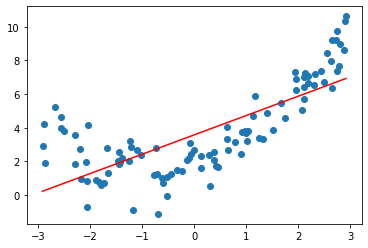

In [23]:
import matplotlib.pyplot as plt
x=np.random.uniform(-3,3,size=100) 
X=x.reshape(-1,1)
y=0.5*x**2+x+2+np.random.normal(0,1,size=100)
from sklearn.linear_model import LinearRegression
reg=LinearRegression()
reg.fit(X,y)
reg.score(X,y)

y_pre=reg.predict(X)
plt.scatter(x,y)
plt.plot(np.sort(x),y_pre[np.argsort(x)],color='r')

from sklearn.metrics import mean_squared_error
mean_squared_error(y,y_pre)

2.287114515300703


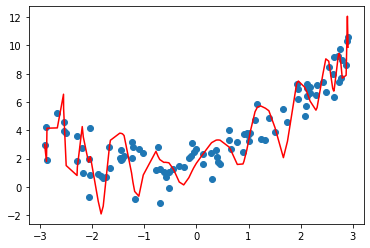

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
def PolynomialRegression(degree):
    return Pipeline([
    ("poly",PolynomialFeatures(degree=degree)),
    ("std_scaler",StandardScaler()),
    ("lin_reg",LinearRegression())
])

poly2_reg =PolynomialRegression(50)
poly2_reg.fit(X,y)
#solve mse
y2_pre = poly2_reg.predict(X)
print(mean_squared_error(y2_pre,y))

plt.scatter(x,y)
plt.plot(np.sort(x),y2_pre[np.argsort(x)],color ='r')

1.0219321354550137


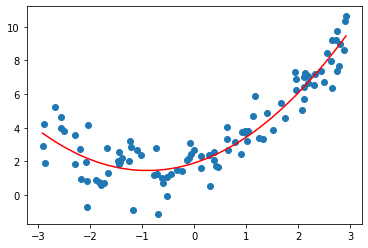

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
def PolynomialRegression(degree):
    return Pipeline([#构建Pipeline
    ("poly",PolynomialFeatures(degree=degree)),#构建PolynomialFeatures
    ("std_scaler",StandardScaler()),#构建归一化StandardScaler
    ("lin_reg",LinearRegression())#构建线性回归LinearRegression
])
#设置degree=2 进行fit拟合
poly2_reg =PolynomialRegression(2)
poly2_reg.fit(X,y)

#solve mse
y2_pre = poly2_reg.predict(X)
print(mean_squared_error(y2_pre,y))

plt.scatter(x,y)
plt.plot(np.sort(x),y2_pre[np.argsort(x)],color ='r')

### 3. Use your own language to explain why dropout can prevent overfitting. Should the neural network rescale the activation output after dropout? Why and why not? Should the neural network apply dropout on the test dataset? Why and why not? 

The reasons why dropout can prevent overfitting:

Dropout randomly knocks out units in the network. So it's as if on every iteration working with a smaller neural network, and so using a smaller neural network seems like it should have a regularizing effect.

The other way is to explain it from the perspective of a single unit. for one unit to do its job as for inputs and it needs to generate some meaningful output. Now with drop out, the inputs can get randomly eliminated. Sometimes those two units will get eliminated, sometimes a different unit will get eliminated. So, what this means is that this unit, which I'm circling in purple, it can't rely on any one feature because any one feature could go away at random or any one of its own inputs could go away at random. Some particular would be reluctant to put all of its bets on, say, just this input. The weights, we're reluctant to put too much weight on any one input because it can go away. So this unit will be more motivated to spread out this way and give you a little bit of weight to each of the four inputs to this unit. And by spreading all the weights, this will tend to have an effect of shrinking the squared norm of the weights. And so, similar to what we saw with L2 regularization, the effect of implementing drop out is that it shrinks the weights and does some of those outer regularization that helps prevent over-fitting.

-----------------------------------------------------------------------
Should the neural network rescale the activation output after dropout?

-----------------------------------------------------------------------
Yes.When the model uses a dropout layer, only the hidden layer units with a proportion of p participate in the training during the training. When predicting, if all hidden layer units need to participate, the result obtained will be larger on average than during training. 1 / p, in order to avoid this, you need to multiply the output result by the test to keep the input scale of the next layer unchanged. With inverted dropout, we can directly expand the weight left by dropout during training, so that the scale of the result can be maintained, and no extra operations are required during prediction, which is more convenient.

---------------------------------------------------------------
Should the neural network apply dropout on the test dataset?

---------------------------------------------------------------

The answer is no.While training, dropout is implemented by only keeping a neuron active with some probability p (a hyperparameter), or setting it to zero otherwise.
Inverting the dropout during the training phase should be preferable.Theoretically if we see Bernoulli dropout as a method of adding noise to the network, it's better that the noise could have a zero mean. If we do the scaling at training time to cancel out the portion of deactivated units, the mean of the noise would be zero.

There are other types of dropout/noise methods came out later that also possess a zero mean.

In terms of training and testing neural networks in practice, there a reason to prefer such implementation as well. Say I want to compare the performance of two models with the same architecture, one is trained by dropout and one is not.

If I "scale the activation at test time", then I'll need two different networks at test time. If I use the "inverted version" then I could just apply the same test network (code) to both sets of trained parameters.

### 4. Gradient exploding and gradient vanishing are two common problems that can appear in deep neural networks. During training, the neural network updates parameters by doing back-propagation and gradient descent. The gradient exploding means that the gradient with respect to a parameter that is far from the output of the neural network could grow exponentially larger during back-propagation. The gradient vanishing means that the gradient with respect to a parameter that is far from the output of the neural network could vanish to zero during the back-propagation process. Use your own language to explain when and why this could happen to our neural network. You can either state your answer intuitively or use Mathematical formulas to prove it.

Gradient disappears often appears in 2 situations: one is in the deep network, and the other is the inappropriate loss function, such as sigmoid. The reason why gradient disappears happenss is when the gradient disappears, the hidden layer close to the output layer is relatively normal due to its gradient, so the weight value is relatively normal, but the closer to the input layer, due to the disappearance of the gradient, it will cause the hidden layer close to the input layer. Weights update slowly or stagnate. This results in the training of the shallow network which is equivalent to the following layers.

Gradient explosion generally occurs in the case of deep networks and weight initialization. In deep neural networks or recurrent neural networks, the gradient of errors can be cumulatively multiplied in the update. If the gradient value between the network layers is greater than 1.0, repeated multiplication will cause the gradient to grow exponentially, the gradient will become very large, and then the network weight will be significantly updated, and thus the network will become unstable.

                                   
-----------------------------------------------------------------

The example here is assuming there is only one neuron per layer and for each layer yi = σ(zi) = σ(wi*xi + bi) , where σ is the sigmoid function. The total number of layer is 4. The output is C. The plot shows like below.

(  ) -------> ( b1 )  ----w2---->  ( b2 )  ----w3---->  ( b3 )  ----w4---->  ( b4 ) --------> C

α C/α b1=αC/αy4  * σ'(z4)w4σ'(z3)w3σ'(z2)w2σ'(z1)

If all| σ'(z) w| <= 0.25, because of the chain rule,as the number of layer become more, αC/αb1 will become less thus the gradient disappears will happen.

If all| σ'(z) w| > 1,the gradient with respect to a parameter that is far from the output of the neural network could grow exponentially larger during back-propagation which means the gradient explode will happen.